In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score
import os
from collections import defaultdict, Counter
import time

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30

# Dataset transformation class
class TransformDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [31]:
class CNNModel(nn.Module):
    def __init__(self, n_classes=10):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(2)
        )

        self.fc_layers = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [32]:
def load_datasets(dataset_dir):
    dataset = datasets.ImageFolder(root=dataset_dir)
    class_names = dataset.classes

    # Count instances per class
    class_counts = Counter([label for _, label in dataset])
    print(f"Class distribution in {dataset_dir}:")
    for class_idx, count in class_counts.items():
        print(f"{class_names[class_idx]}: {count} images")

    indices = list(range(len(dataset)))
    np.random.shuffle(indices)

    train_split = int(0.7 * len(indices))
    val_split = int(0.85 * len(indices))

    train_indices = indices[:train_split]
    val_indices = indices[train_split:val_split]
    test_indices = indices[val_split:]

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_dataset = TransformDataset(torch.utils.data.Subset(dataset, train_indices), transform=transform)
    val_dataset = TransformDataset(torch.utils.data.Subset(dataset, val_indices), transform=transform)
    test_dataset = TransformDataset(torch.utils.data.Subset(dataset, test_indices), transform=transform)

    return DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True), \
           DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False), \
           DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False), \
           class_names


In [33]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = (correct / total) * 100

        val_loss = 0.0
        val_correct = 0
        val_total = 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = (val_correct / val_total) * 100

        scheduler.step(val_loss)

        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        epoch_time = time.time() - start_time

        print(f"Epoch [{epoch+1}/{epochs}], Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [34]:
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_labels, all_predictions = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels)) * 100
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')

    print(f"Test Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}, Recall: {recall:.2f}")

In [35]:
def process_dataset(dataset_dir):
    plant_name = os.path.basename(dataset_dir)
    print(f"\nProcessing {plant_name} Dataset")

    train_loader, val_loader, test_loader, class_names = load_datasets(dataset_dir)
    model = CNNModel(n_classes=len(class_names)).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Lower LR + L2 regularization
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

    train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, EPOCHS)
    evaluate_model(model, test_loader, class_names)

    # Save models
    torch.save(model, f'{plant_name}_cnn_model_full.pth')
    torch.save(model.state_dict(), f'{plant_name}_cnn_model_state_dict.pth')


Processing Cotton Dataset


Class distribution in /home/kkt/research/cropsight/Cotton:
bacterial_blight: 448 images
curl_virus: 417 images
fussarium_wilt: 419 images
healthy: 426 images
Epoch [1/30], Time: 9.01s, Train Loss: 0.9229, Train Acc: 62.3225, Val Loss: 0.7912, Val Acc: 72.2656
Epoch [2/30], Time: 9.11s, Train Loss: 0.7330, Train Acc: 72.5982, Val Loss: 0.6743, Val Acc: 75.0000
Epoch [3/30], Time: 9.03s, Train Loss: 0.6733, Train Acc: 74.8538, Val Loss: 0.6020, Val Acc: 80.0781
Epoch [4/30], Time: 9.02s, Train Loss: 0.6041, Train Acc: 78.1119, Val Loss: 0.5840, Val Acc: 76.5625
Epoch [5/30], Time: 9.00s, Train Loss: 0.5328, Train Acc: 82.2055, Val Loss: 0.5252, Val Acc: 78.9062
Epoch [6/30], Time: 8.98s, Train Loss: 0.4833, Train Acc: 83.2916, Val Loss: 0.5366, Val Acc: 80.4688
Epoch [7/30], Time: 9.00s, Train Loss: 0.4406, Train Acc: 85.2130, Val Loss: 0.5406, Val Acc: 77.7344
Epoch [8/30], Time: 9.02s, Train Loss: 0.4413, Train Acc: 84.7118, Val Loss: 0.6318, Val Acc: 74.6094
Epoch [9/30], Time: 9.02s,

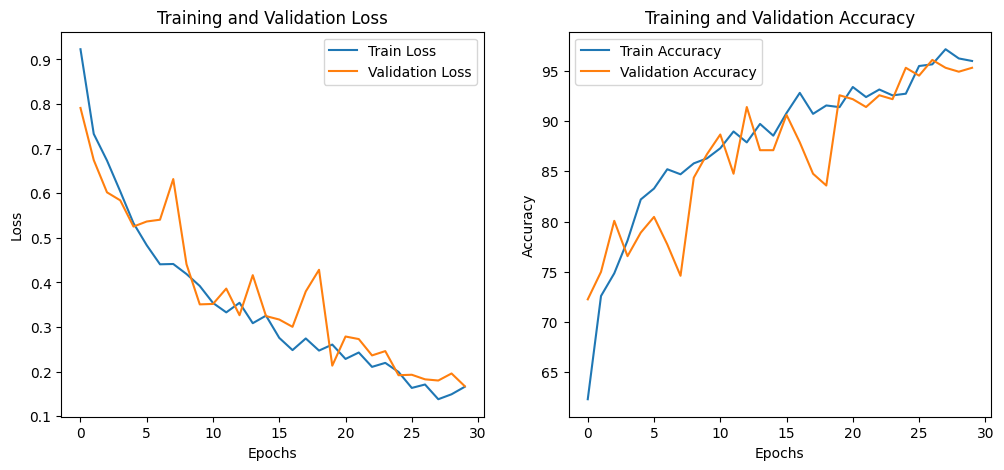

Test Accuracy: 98.05%, Precision: 0.98, Recall: 0.98


In [36]:
process_dataset('/home/kkt/research/cropsight/Cotton')


Processing Potato Dataset
Class distribution in /home/kkt/research/cropsight/Potato:
Early_Blight: 1000 images
Healthy: 152 images
Late_Blight: 1000 images
Epoch [1/30], Time: 5.60s, Train Loss: 0.4348, Train Acc: 87.1182, Val Loss: 0.3884, Val Acc: 88.8545
Epoch [2/30], Time: 5.58s, Train Loss: 0.2651, Train Acc: 93.2271, Val Loss: 0.1515, Val Acc: 95.9752
Epoch [3/30], Time: 5.56s, Train Loss: 0.2285, Train Acc: 95.4847, Val Loss: 0.1328, Val Acc: 95.3560
Epoch [4/30], Time: 5.55s, Train Loss: 0.1702, Train Acc: 94.9535, Val Loss: 0.1407, Val Acc: 95.6656
Epoch [5/30], Time: 5.57s, Train Loss: 0.1470, Train Acc: 96.1487, Val Loss: 0.1247, Val Acc: 96.5944
Epoch [6/30], Time: 5.57s, Train Loss: 0.1257, Train Acc: 97.3440, Val Loss: 0.0910, Val Acc: 97.5232
Epoch [7/30], Time: 5.77s, Train Loss: 0.1068, Train Acc: 97.6096, Val Loss: 0.1213, Val Acc: 95.6656
Epoch [8/30], Time: 5.64s, Train Loss: 0.1397, Train Acc: 97.0784, Val Loss: 0.0696, Val Acc: 97.8328
Epoch [9/30], Time: 5.57s, 

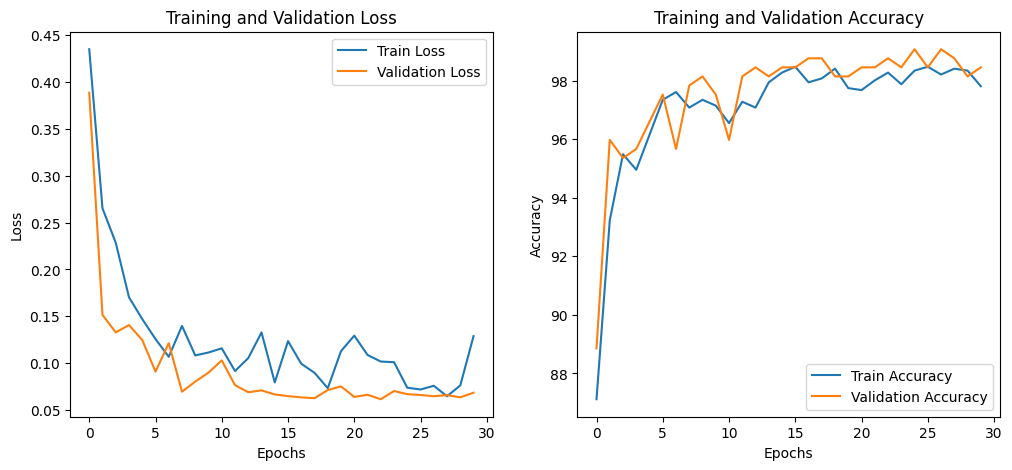

Test Accuracy: 97.21%, Precision: 0.97, Recall: 0.97


In [37]:
process_dataset('/home/kkt/research/cropsight/Potato')


Processing Wheat Dataset
Class distribution in /home/kkt/research/cropsight/Wheat:
Brown_Rust: 902 images
Healthy: 1116 images
Yellow_Rust: 924 images
Epoch [1/30], Time: 16.58s, Train Loss: 0.3302, Train Acc: 88.5867, Val Loss: 0.1771, Val Acc: 93.8776
Epoch [2/30], Time: 16.54s, Train Loss: 0.1706, Train Acc: 94.8519, Val Loss: 0.1366, Val Acc: 96.1451
Epoch [3/30], Time: 16.71s, Train Loss: 0.1395, Train Acc: 95.9203, Val Loss: 0.1518, Val Acc: 95.2381
Epoch [4/30], Time: 16.67s, Train Loss: 0.1238, Train Acc: 96.4546, Val Loss: 0.0860, Val Acc: 97.0522
Epoch [5/30], Time: 16.71s, Train Loss: 0.1117, Train Acc: 96.5517, Val Loss: 0.1217, Val Acc: 95.9184
Epoch [6/30], Time: 16.65s, Train Loss: 0.1101, Train Acc: 96.5032, Val Loss: 0.0583, Val Acc: 99.3197
Epoch [7/30], Time: 16.68s, Train Loss: 0.0935, Train Acc: 96.9888, Val Loss: 0.0565, Val Acc: 98.8662
Epoch [8/30], Time: 16.57s, Train Loss: 0.0887, Train Acc: 96.7946, Val Loss: 0.2042, Val Acc: 92.0635
Epoch [9/30], Time: 16.4

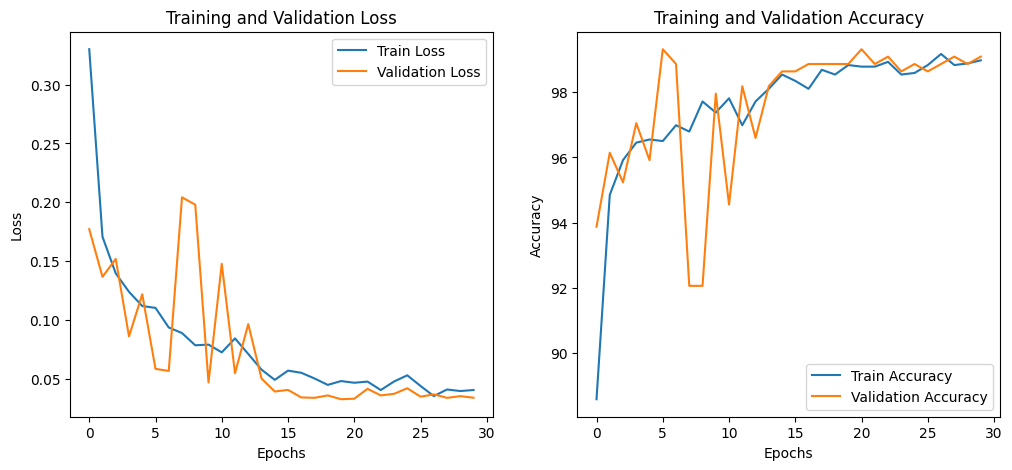

Test Accuracy: 98.42%, Precision: 0.98, Recall: 0.98


In [38]:
process_dataset('/home/kkt/research/cropsight/Wheat')